In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


In [11]:

spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .getOrCreate()

23/10/24 23:18:37 WARN Utils: Your hostname, charles resolves to a loopback address: 127.0.1.1; using 192.168.1.204 instead (on interface wlo1)
23/10/24 23:18:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/24 23:18:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [17]:
sapiq_df = spark.read.json("data/sapiq.json", multiLine=True)


In [25]:
sapiq_df.printSchema()

root
 |-- customer_focus: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: long (nullable = true)
 |-- id: string (nullable = true)
 |-- next_yoy_growth: double (nullable = true)
 |-- revenue: double (nullable = true)
 |-- sectors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- yoy_growth: double (nullable = true)



## fechas

In [37]:
sapiq_df\
    .select("date")\
    .summary("count", "min", "max")\
    .withColumn("date_to_date", 
                F.to_date(F.from_unixtime(F.col('date')/1000)))\
    .toPandas()

,summary,date,date_to_date
0,count,766,1970-01-01
1,min,986083200000,2001-04-01
2,max,1320105600000,2011-11-01


## empresas distintas

In [24]:

sapiq_df.groupBy("id")\
        .agg(F.count("*").alias("registros_por_empresa"))\
        .groupBy("registros_por_empresa")\
        .agg(F.count("*").alias("empresas_distintas"))\
        .select("empresas_distintas", "registros_por_empresa")\
        .orderBy("empresas_distintas", "registros_por_empresa")\
        .toPandas()

,empresas_distintas,registros_por_empresa
0,2,5
1,2,12
2,2,15
3,3,11
4,3,13
5,3,16
6,4,10
7,5,7
8,6,14
9,7,6


In [39]:
sapiq_df.withColumn("customers", F.size(F.col("customer_focus")))\
        .withColumn("sectors", F.size(F.col("sectors")))\
        .groupBy("customers", "sectors")\
        .count()\
        .toPandas()

,customers,sectors,count
0,1,1,766


## Customer distintos

In [43]:
sapiq_df.withColumn("customer_id", F.col("customer_focus").getItem(0))\
        .groupBy("customer_id")\
        .count()\
        .show(truncate=False)

+----------------------------------------------------------------+-----+
|customer_id                                                     |count|
+----------------------------------------------------------------+-----+
|3345821e031f176625606aa47a2e8bf7492f22e19315924a141371a9349915e8|668  |
|5527f7356a87cec5d061767332baf6dd52a8d98ad469704be27e6eb403ab92e7|98   |
+----------------------------------------------------------------+-----+



## Sectores distintos

In [44]:
sapiq_df.withColumn("sector_id", F.col("sectors").getItem(0))\
        .groupBy("sector_id")\
        .count()\
        .show(truncate=False)

+----------------------------------------------------------------+-----+
|sector_id                                                       |count|
+----------------------------------------------------------------+-----+
|3fbe5ed156f149939d9396e729af009070ccc54984b5bd8e088d86a72f8ac879|533  |
|4bf3fcb1090c5362f115577582e490079c659107fa05bad1a54d239b95a1abf7|67   |
|776de885df4110bf359fdbf78f2b39059d5da13a1b79f49f2e1963e3cec23580|110  |
|6d4a245c55c115dfc0f1152d9383924c3ef68c1f03951332542d867e19de865f|56   |
+----------------------------------------------------------------+-----+



In [1]:
base_data = {
        "id": "23d62860a03b91c69058cccc07fc545910a1c115d9fb22ac09b79365b4c0369f",
        "date": 986083200000,
        "customer_focus": [
        ],
        "sectors": [
        ],
        "revenue": 205.4970259821,
        "yoy_growth": 1.0004409029,
        "next_yoy_growth": 0.8096898135
    }
base_company_info = {
    "company_id": "23d62860a03b91c69058cccc07fc545910a1c115d9fb22ac09b79365b4c0369f",
    "latest_known_dt": "2011-11-01",
    "data":[]
}

In [2]:
sectors = ["3fbe5ed156f149939d9396e729af009070ccc54984b5bd8e088d86a72f8ac879",
           "4bf3fcb1090c5362f115577582e490079c659107fa05bad1a54d239b95a1abf7",
           "776de885df4110bf359fdbf78f2b39059d5da13a1b79f49f2e1963e3cec23580",
           "6d4a245c55c115dfc0f1152d9383924c3ef68c1f03951332542d867e19de865f"]
customers = ["3345821e031f176625606aa47a2e8bf7492f22e19315924a141371a9349915e8",
             "5527f7356a87cec5d061767332baf6dd52a8d98ad469704be27e6eb403ab92e7"]



## Sensibilidad a customer

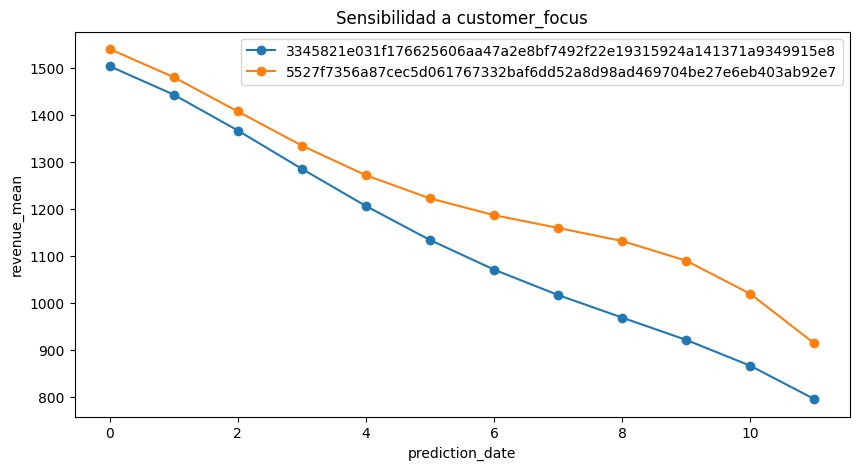

In [32]:
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
from cli import main as predictor
import pandas as pd

# Obtener el timestamp actual

sector_fijo = dict(base_data)
sector_fijo["sectors"] = sectors[0:1]

plt.figure(figsize=(10, 5))
plt.clf()
for customer in customers:
    timestamp = datetime.now().timestamp()
    formatted_timestamp = str(int(timestamp))
    current_data = dict(sector_fijo)
    current_data["customer_focus"] = [customer]
    current_company_info = dict(base_company_info)
    current_company_info["data"].append(current_data)
    # Crear y escribir en el fichero JSON
    json_file_name = f'./tmp/{formatted_timestamp}.json'
    with open(json_file_name, 'w') as f:
        json.dump(current_company_info, f)
    predictor(database_file_path = "data/sapiq.json", 
              json_data_path = json_file_name, 
              output_file_path = json_file_name)
    with open(json_file_name, "r") as f:
        prediction_data = json.loads(json.load(f))

    predictions = pd.DataFrame(prediction_data)
    predictions.set_index("prediction_date")
    plt.plot(predictions["revenue_mean"], label=customer, marker='o')


plt.xlabel('prediction_date')
plt.ylabel('revenue_mean')
plt.title('Sensibilidad a customer_focus')
plt.legend()

# Mostrar el plot
plt.show()
    
    

## Sensibilidad a sector

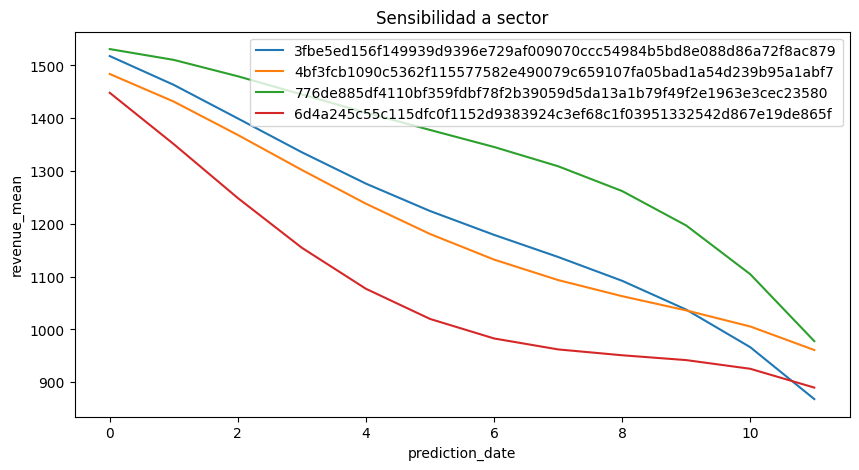

In [26]:
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
from cli import main as predictor
import pandas as pd

# Obtener el timestamp actual

customer_fijo = dict(base_data)
customer_fijo["customer_focus"] = customers[0:1]

plt.figure(figsize=(10, 5))
plt.clf()
for sector in sectors:
    timestamp = datetime.now().timestamp()
    formatted_timestamp = str(int(timestamp))
    current_data = dict(customer_fijo)
    current_data["sectors"] = [sector]
    current_company_info = dict(base_company_info)
    current_company_info["data"].append(current_data)
    # Crear y escribir en el fichero JSON
    json_file_name = f'./tmp/{formatted_timestamp}.json'
    with open(json_file_name, 'w') as f:
        json.dump(current_company_info, f)
    predictor(database_file_path = "data/sapiq.json", 
              json_data_path = json_file_name, 
              output_file_path = json_file_name)
    with open(json_file_name, "r") as f:
        prediction_data = json.loads(json.load(f))

    predictions = pd.DataFrame(prediction_data)
    predictions.set_index("prediction_date")
    plt.plot(predictions["revenue_mean"], label=sector, marker='o')


plt.xlabel('prediction_date')
plt.ylabel('revenue_mean')
plt.title('Sensibilidad a sector')
plt.legend()

# Mostrar el plot
plt.show()
    
    